In [1]:
# Read the data
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFlipp.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFlipp.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFlipp.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFlipp.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFlipp.mat')

AllFacesData = np.concatenate((BahramFace['Intensification_Data'],
                               DJFace['Intensification_Data'],
                               NickFace['Intensification_Data'],
                               RoohiFace['Intensification_Data'],
                               SarahFace['Intensification_Data']), axis=0)

AllFacesLabel = np.concatenate((BahramFace['Intensification_Label'],
                                DJFace['Intensification_Label'],
                                NickFace['Intensification_Label'],
                                RoohiFace['Intensification_Label'],
                                SarahFace['Intensification_Label']), axis=0)

AllFacesLabelOne = (AllFacesLabel==1).reshape(-1)
AllFacesData_LabelOne = AllFacesData[AllFacesLabelOne]

AllFacesLabelZero = (AllFacesLabel==0).reshape(-1)
AllFacesData_LabelZero = AllFacesData[AllFacesLabelZero]

# Linear synthetic data augmentatiion or creation or generation
AllFacesData_LabelOneNew_list = []

# w*data+b: translation, rotation, and scaling
# linear transformation of the target data
w, b = 1.0, 0.0
for idx in range(5):
    AllFacesData_LabelOneNew = (w * AllFacesData_LabelOne) + b
    AllFacesData_LabelOneNew_list.append(AllFacesData_LabelOneNew)
    w *= 0.9 # 1.0, 0.9, 0.81, 0.729
    b += 0.1 # 0.1, 0.2, 0.3

AllFacesData_LabelOneNew_total = np.array(AllFacesData_LabelOneNew_list, 
                                      dtype=AllFacesData_LabelOne.dtype).reshape(-1, 205, 16)

AllFacesDataNew = np.concatenate((AllFacesData_LabelOneNew_total, AllFacesData_LabelZero), axis=0)

AllFacesLabelNew = np.concatenate((AllFacesLabel[AllFacesLabelZero], # Tgt = 6*Non-Tgt
                                   AllFacesLabel[AllFacesLabelOne],
                                   AllFacesLabel[AllFacesLabelOne],
                                   AllFacesLabel[AllFacesLabelOne], 
                                   AllFacesLabel[AllFacesLabelOne], 
                                   AllFacesLabel[AllFacesLabelOne]), axis=0)

print(AllFacesDataNew.shape, AllFacesDataNew.dtype, AllFacesLabelNew.shape, AllFacesLabelNew.dtype)
print(np.mean(AllFacesLabelNew==0), np.mean(AllFacesLabelNew==1))
print((AllFacesLabelNew +  1).max(axis=0))

(31500, 205, 16) float64 (31500, 1) uint8
0.5 0.5
[2]


In [2]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllFacesDataNew, AllFacesLabelNew, 
                                                                test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(22050, 205, 16) (9450, 205, 16) (22050, 1) (9450, 1)


In [3]:
# Pre-processing input and output data
from utilities import *

# Normalizing the input data
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# # Onehot encoding/vectorizing the output labels/ data
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.498820861678 0.501179138322 0.0
(22050, 2) float64 (9450, 2) float64


In [5]:
# Train and valid split
# from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(15435, 205, 16) (6615, 205, 16) (15435, 2) (6615, 2)


In [6]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 154 205 16
n_classes [2]


In [7]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [8]:
#  Buffering/ placeholders to transfer the data from py to tf
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [9]:
# with graph.as_default():
# batch_size, seq_len, n_channels: 218 205 16
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print(inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print(max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print(max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=3, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print(max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print(max_pool_4.shape, flat.shape, logits.shape)

(?, 205, 16) (?, 204, 32) (?, 102, 32)
(?, 102, 32) (?, 102, 64) (?, 51, 64)
(?, 51, 64) (?, 50, 128) (?, 25, 128)
(?, 25, 128) (?, 24, 256) (?, 12, 256)
(?, 12, 256) (?, 3072) (?, 2)


In [12]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print(correct_pred, accuracy)

# Confusion matrix
confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print(confusion_matrix)

Tensor("Equal_2:0", shape=(?,), dtype=bool) Tensor("accuracy_2:0", shape=(), dtype=float32)
Tensor("confusion_matrix_2/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [13]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 1/100 Train loss: 0.701912 Valid loss: 0.676955 Train acc: 0.532987 Valid acc: 0.558664
Epoch: 2/100 Train loss: 0.678280 Valid loss: 0.659171 Train acc: 0.575162 Valid acc: 0.608673
Epoch: 3/100 Train loss: 0.656269 Valid loss: 0.639078 Train acc: 0.610887 Valid acc: 0.643293
Epoch: 4/100 Train loss: 0.632769 Valid loss: 0.616607 Train acc: 0.640812 Valid acc: 0.670805
Epoch: 5/100 Train loss: 0.610448 Valid loss: 0.594388 Train acc: 0.664766 Valid acc: 0.692413
Epoch: 6/100 Train loss: 0.590348 Valid loss: 0.574320 Train acc: 0.684069 Valid acc: 0.709663
Epoch: 7/100 Train loss: 0.571919 Valid loss: 0.556700 Train acc: 0.699842 Valid acc: 0.723627
Epoch: 8/100 Train loss: 0.556391 Valid loss: 0.541779 Train acc: 0.712451 Valid acc: 0.734702
Epoch: 9/100 Train loss: 0.542809 Valid loss: 0.529027 Train acc: 0.723384 Valid acc: 0.743834
Epoch: 10/100 Train loss: 0.530440 Valid loss: 0.517911 Train acc: 0.732766 Valid acc: 0.751563
Epoch: 11/100 Train loss: 0.520035 Valid loss: 0.

Epoch: 87/100 Train loss: 0.285492 Valid loss: 0.339623 Train acc: 0.877480 Valid acc: 0.853074
Epoch: 88/100 Train loss: 0.284065 Valid loss: 0.338853 Train acc: 0.878160 Valid acc: 0.853470
Epoch: 89/100 Train loss: 0.282669 Valid loss: 0.338102 Train acc: 0.878846 Valid acc: 0.853856
Epoch: 90/100 Train loss: 0.281247 Valid loss: 0.337393 Train acc: 0.879535 Valid acc: 0.854228
Epoch: 91/100 Train loss: 0.279847 Valid loss: 0.336671 Train acc: 0.880233 Valid acc: 0.854598
Epoch: 92/100 Train loss: 0.278491 Valid loss: 0.335999 Train acc: 0.880891 Valid acc: 0.854952
Epoch: 93/100 Train loss: 0.277081 Valid loss: 0.335283 Train acc: 0.881569 Valid acc: 0.855324
Epoch: 94/100 Train loss: 0.275721 Valid loss: 0.334590 Train acc: 0.882204 Valid acc: 0.855685
Epoch: 95/100 Train loss: 0.274359 Valid loss: 0.333913 Train acc: 0.882872 Valid acc: 0.856040
Epoch: 96/100 Train loss: 0.272995 Valid loss: 0.333216 Train acc: 0.883548 Valid acc: 0.856401
Epoch: 97/100 Train loss: 0.271642 Valid

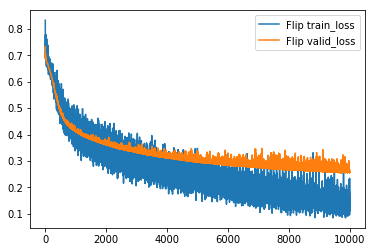

In [20]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='Flip train_loss')
mplot.plot(valid_loss, label='Flip valid_loss')
mplot.legend()
mplot.show()

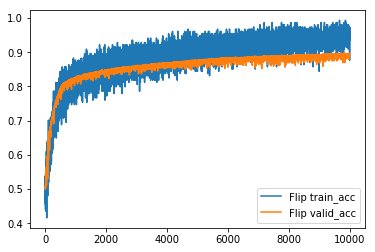

In [21]:
mplot.plot(train_acc, label='Flip train_acc')
mplot.plot(valid_acc, label='Flip valid_acc')
mplot.legend()
mplot.show()

In [23]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc, confusion = sess.run([cost, accuracy, confusion_matrix], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test loss: 0.289769 Test acc: 0.882798


In [19]:
# mplot.imshow(confusion)
# mplot.show()